<a href="https://colab.research.google.com/github/RussiANC00lHACKA/ml_textbook/blob/main/Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***О задаче***

### Контекст  
Важно, чтобы компании, выпускающие кредитные карты, могли распознавать мошеннические транзакции, чтобы клиенты не были обязаны оплачивать товары, которые они не покупали.

### Содержание  
Данный датасет содержит информацию о транзакциях, совершенных с использованием кредитных карт в сентябре 2013 года европейскими держателями карт.  

В этом датасете представлены транзакции за два дня, в ходе которых было зафиксировано 492 случая мошенничества из 284,807 транзакций. Датасет сильно несбалансирован: положительный класс (мошенничество) составляет всего 0.172% от всех транзакций.  

Датасет содержит только числовые признаки, которые были получены в результате преобразования методом PCA (анализ главных компонент). К сожалению, из-за вопросов конфиденциальности оригинальные признаки и дополнительная информация о данных недоступны. Признаки V1, V2, … V28 — это главные компоненты, полученные с помощью PCA. Единственными признаками, которые не подвергались преобразованию методом PCA, являются 'Time' и 'Amount'. Признак 'Time' содержит количество секунд, прошедших с момента первой транзакции в датасете до каждой следующей транзакции. Признак 'Amount' — это сумма транзакции, которую можно использовать для учета зависимости от примера при обучении с учетом стоимости ошибок. Признак 'Class' — это целевая переменная, принимающая значение 1 в случае мошенничества и 0 в противном случае.  

In [1]:
! kaggle datasets download mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 85% 56.0M/66.0M [00:00<00:00, 160MB/s]
100% 66.0M/66.0M [00:00<00:00, 146MB/s]


In [2]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('creditcard.csv')

In [6]:
df.shape

(284807, 31)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# ***Теория для дальнейшего понимания вопроса!***

Несбалансированные данные — это ситуация, чаще всего встречающаяся в задачах классификации, когда один из целевых классов значительно преобладает в выборке. Такие наборы данных характеризуются сильным дисбалансом в распределении классов, например, 1:100 или 1:1000 наблюдений в классе меньшинства по сравнению с классом большинства.

Проблема дисбаланса классов возникает в различных сферах, например:  

- **Обнаружение мошенничества**: подавляющее большинство транзакций относятся к классу «Не мошенничество».  
- **Медицинская диагностика**: большинство людей в выборке оказываются здоровыми.  
- **Анализ оттока подписчиков**: большинство пользователей остаются с сервисом, что формирует класс «Без оттока».  
- **Реклама и прогнозирование кликов**: данные о кликах обычно имеют крайне низкий уровень кликабельности.  

Существуют различные методы для устранения дисбаланса классов перед обучением модели, в том числе:  

- Увеличение числа наблюдений для класса меньшинства, используя знания о предметной области.  
- Модификация функции потерь, чтобы ошибки для класса меньшинства наказывались сильнее.  
- Увеличение выборки (oversampling) за счет создания или дублирования данных для класса меньшинства.  
- Уменьшение выборки (undersampling) за счет удаления или объединения данных для класса большинства.  
- Комбинация нескольких подходов.  

При увеличении выборки создаются новые или дублируются существующие примеры для класса меньшинства, а при уменьшении выборки удаляются или объединяются данные класса большинства. Несмотря на то, что увеличение выборки используется чаще всего, оно не всегда является лучшим решением.

Пример: ![Текст ссылки](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*miAWYUJ7sgWaRHCZMdP2OQ.png)

In [8]:
labels=["Genuine","Class"]

fraud_or_not = df["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

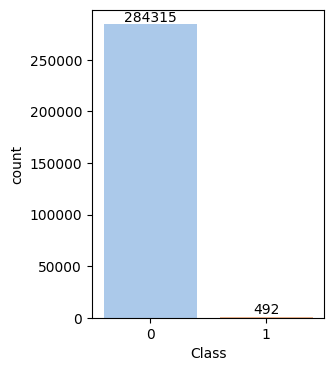

In [11]:
plt.figure(figsize=(3,4));
ax = sns.countplot(x='Class',data=df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [21]:
print('Genuine:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% от датасета')
print('Frauds:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% от датасета')

Genuine: 99.83 % от датасета
Frauds: 0.17 % от датасета


Как по графикам можно заметить, мы занимаемся задачей с **несбалансированными данными** с экстремальными пропорциями, например, `99:1` или `99.9:0.1.`

Мы будем использовать именно бустинг с этими данными. **Но почему его?**

Мы выбираем его, потому что:

1. Он автоматически обращает внимание на редкие, сложные примеры.
2. У него есть настройки, чтобы учитывать дисбаланс (например, вес классов).
3. Он обычно дает точные результаты, даже если данные неидеальны.

# ***Точность классификации?***

Все вы знаете как работает точность и зачем она нужна!

Но какая же основная проблема этой метрики, связанная с дисбалансом классов и можно ли ее использовать в нашей задаче?

Достичь `90%` или даже `99%` точности может быть очень просто при работе с несбалансированными данными. Рассмотрим случай, когда данные имеют дисбаланс классов `1:100`. Если модель будет «слепо угадывать», всегда выбирая доминирующий класс, то её точность составит `99%`. Поэтому accuracy нам не будет подходить!

# ***Какие метрики будем использовать?***

- Предсказываете ли вы вероятности?
  - Нужны ли вам метки классов?
    - Является ли положительный класс более важным? - используйте **Precision-Recall AUC**
    - Оба класса важны? - используйте **ROC AUC**
  - Нужны ли вам вероятности? - используйте **Brier Score** и **Log-loss Score**

- Предсказываете ли вы метки классов?
  - Является ли положительный класс более важным?
    - Ложноотрицательные и ложноположительные равнозначно важны? - используйте **F1-Measure**
    - Ложноотрицательные важнее? - используйте **F2-Measure**
    - Ложноположительные важнее? - используйте **F0.5-Measure**
  - Оба класса важны?
    - Если доля большинства меньше 80%-90% - используйте **Accuracy**
    - Если доля большинства больше 80%-90% - используйте **G-Mean**


Что же мы будем использовать под нашу задачу?


Мы предсказываем очевидно метки классов (потому что у нас задача классификации), также мне кажется нам важны и ложноположительные и ложноотрицательные результаты, поэтому можно использовать **F1-Measure** (возможны и другие ответы в данном подпункте)

# ***Удаление выбросов***
Нужно ли удалять выбросы, как вы думаете и если вы будете их удалять какой метод удаления будете использовать?

Ответ:
1. В этом датасете мошеннические транзакции встречаются крайне редко — всего `0.172%` от всех данных.
Эти данные по своей природе выглядят как выбросы в контексте общих тенденций: они могут иметь необычные значения по признакам, которые сильно отличаются от нормальных транзакций.
2. Признаки в этом датасете были получены с использованием `PCA`, что уменьшает размерность данных и сводит к минимуму влияние шума. Выбросы, которые могут быть вызваны шумом, уже смягчены этим преобразованием.

# ***Работа с данными***

In [13]:
X = df.drop('Class', axis=1)
y = df['Class']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

***ВАЖНО:***
Нужно использовать ***стратифицированное разбиение***!
Обычно такие разделения набора данных выполняются случайным образом на основе целевой переменной. Однако при случайном разбиении пропорции целевой переменной в разных частях могут различаться, особенно в случае небольших наборов данных.

In [12]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [22]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
# Рассчитаем веса для классов
negative_weight = len(y_train == 0) / len(y_train)
positive_weight = len(y_train == 1) / len(y_train)
class_weights = [1 / negative_weight, 1 / positive_weight]  # Инвертируем соотношение

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100,
    class_weights=class_weights  # Указываем веса классов
)

# Обучение модели
model.fit(X_train, y_train)


y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
y_pred = (y_pred_proba >= 0.5).astype(int)       # Классификация по порогу 0.5

# Вывод метрик
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))


precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


0:	learn: 0.3650448	total: 72.5ms	remaining: 36.2s
100:	learn: 0.0013354	total: 6.44s	remaining: 25.4s
200:	learn: 0.0009363	total: 14.2s	remaining: 21.2s
300:	learn: 0.0006908	total: 19.9s	remaining: 13.2s
400:	learn: 0.0004591	total: 27.9s	remaining: 6.88s
499:	learn: 0.0003023	total: 33.6s	remaining: 0us
ROC-AUC Score: 0.9706904336777131
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.76      0.85       148

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Precision-Recall AUC: 0.8312641350778284


In [25]:
from sklearn.metrics import fbeta_score

f1_score = fbeta_score(y_test, y_pred, beta=1)
print("F1-Score:", f1_score)

F1-Score: 0.849624060150376


In [31]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import numpy as np

# Базовая модель CatBoost
base_model = CatBoostClassifier(
    random_seed=42,
    verbose=100,
    class_weights=class_weights
)

# Сетка параметров для поиска
param_grid = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'depth': [4, 6, 8]
}

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,  # 3-кратная кросс-валидация
    verbose=2,
    n_jobs=-1  # Параллельное выполнение
)

# Обучение с подбором параметров
grid_search.fit(X_train, y_train)

# Лучшие параметры и метрика
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1 Score на кросс-валидации:", grid_search.best_score_)

# Лучшая модель
best_model = grid_search.best_estimator_

# Оценка на тестовой выборке
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, y_pred_proba))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
0:	learn: 0.5036760	total: 96.2ms	remaining: 28.7s
100:	learn: 0.0022082	total: 7.72s	remaining: 15.2s
200:	learn: 0.0018246	total: 12.3s	remaining: 6.08s
299:	learn: 0.0015423	total: 18.6s	remaining: 0us
Лучшие параметры: {'depth': 4, 'iterations': 300, 'learning_rate': 0.05}
Лучший ROC-AUC Score на кросс-валидации: 0.8651847140424538
ROC-AUC на тестовой выборке: 0.9709289936516035


In [33]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=False)
score = cross_val_score(best_model, X_train, y_train, cv=kf, scoring='f1')
print("Cross Validation F1-scores are: {}".format(score))
print("Average Cross Validation F1-score: {}".format(score.mean()))

0:	learn: 0.5050428	total: 120ms	remaining: 35.9s
100:	learn: 0.0022921	total: 9.96s	remaining: 19.6s
200:	learn: 0.0018782	total: 21.5s	remaining: 10.6s
299:	learn: 0.0015606	total: 26.4s	remaining: 0us
0:	learn: 0.5025703	total: 128ms	remaining: 38.3s
100:	learn: 0.0020619	total: 7.93s	remaining: 15.6s
200:	learn: 0.0016655	total: 15.7s	remaining: 7.75s
299:	learn: 0.0014117	total: 23.4s	remaining: 0us
0:	learn: 0.5035628	total: 40.6ms	remaining: 12.2s
100:	learn: 0.0022630	total: 3.93s	remaining: 7.75s
200:	learn: 0.0018450	total: 10.1s	remaining: 4.98s
299:	learn: 0.0015789	total: 13.9s	remaining: 0us
0:	learn: 0.5054302	total: 39.3ms	remaining: 11.7s
100:	learn: 0.0022418	total: 3.94s	remaining: 7.76s
200:	learn: 0.0018032	total: 10.1s	remaining: 4.99s
299:	learn: 0.0015360	total: 13.9s	remaining: 0us
0:	learn: 0.5042007	total: 48.3ms	remaining: 14.4s
100:	learn: 0.0020626	total: 3.98s	remaining: 7.84s
200:	learn: 0.0016642	total: 10.1s	remaining: 4.96s
299:	learn: 0.0013875	total

# ***Визуализация важности признаков***

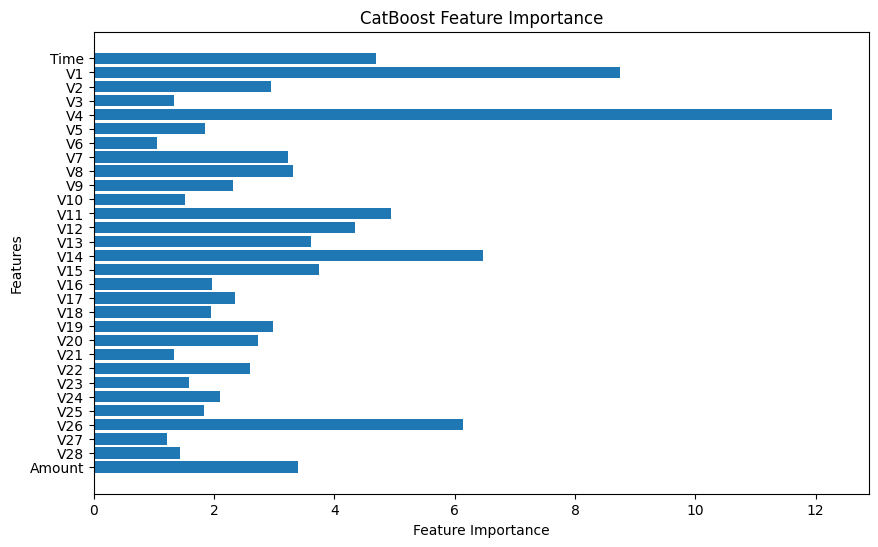

In [44]:
from catboost import Pool
feature_importances = model.get_feature_importance(Pool(X_test, y_test))
feature_names = X_train.columns

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# ***Ансамбль моделей***

In [37]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    scale_pos_weight=20,
    random_state=42
)

# Создание ансамбля
ensemble = VotingClassifier(
    estimators=[
        ('catboost', best_model),
        ('xgb', xgb_model),
    ],
    voting='soft'
)
ensemble.fit(X_train, y_train)


y_pred_ensemble = ensemble.predict(X_test)
y_pred_ensemble_proba = ensemble.predict_proba(X_test)[:, 1]

print("ROC-AUC Score (Ensemble):", roc_auc_score(y_test, y_pred_ensemble_proba))
print("\nClassification Report (Ensemble):")
print(classification_report(y_test, y_pred_ensemble))


0:	learn: 0.5036760	total: 53.2ms	remaining: 15.9s
100:	learn: 0.0022082	total: 7.45s	remaining: 14.7s
200:	learn: 0.0018246	total: 14.7s	remaining: 7.22s
299:	learn: 0.0015423	total: 24.5s	remaining: 0us
ROC-AUC Score (Ensemble): 0.9723781375607391

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [40]:
f1_score_ens = fbeta_score(y_test, y_pred_ensemble, beta=1)
print("F1-Score:", f1_score_ens)

F1-Score: 0.8529411764705882


In [42]:
kf = StratifiedKFold(n_splits=5, shuffle=False)
score = cross_val_score(ensemble, X_train, y_train, cv=kf, scoring='f1')
print("Cross Validation F1-scores are: {}".format(score))
print("Average Cross Validation F1-score: {}".format(score.mean()))

0:	learn: 0.5050428	total: 88.8ms	remaining: 26.6s
100:	learn: 0.0022921	total: 4.36s	remaining: 8.6s
200:	learn: 0.0018782	total: 8.71s	remaining: 4.29s
299:	learn: 0.0015606	total: 15.8s	remaining: 0us
0:	learn: 0.5025703	total: 58.5ms	remaining: 17.5s
100:	learn: 0.0020619	total: 3.9s	remaining: 7.67s
200:	learn: 0.0016655	total: 7.79s	remaining: 3.83s
299:	learn: 0.0014117	total: 14.1s	remaining: 0us
0:	learn: 0.5035628	total: 39.6ms	remaining: 11.8s
100:	learn: 0.0022630	total: 3.92s	remaining: 7.72s
200:	learn: 0.0018450	total: 10.1s	remaining: 4.96s
299:	learn: 0.0015789	total: 13.9s	remaining: 0us
0:	learn: 0.5054302	total: 41.1ms	remaining: 12.3s
100:	learn: 0.0022418	total: 6.18s	remaining: 12.2s
200:	learn: 0.0018032	total: 10s	remaining: 4.94s
299:	learn: 0.0015360	total: 13.8s	remaining: 0us
0:	learn: 0.5042007	total: 38.9ms	remaining: 11.6s
100:	learn: 0.0020626	total: 6.24s	remaining: 12.3s
200:	learn: 0.0016642	total: 13.7s	remaining: 6.74s
299:	learn: 0.0013875	total: 

# Ссылки на kaggle: [ссылка1](https://www.kaggle.com/code/youssefelbadry10/credit-card-fraud-detection#2-Preprocessing), [ссылка2](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset#1.-Introduction)